# Classification of Malicious URL using Deep Learning via Keras


In [1]:
!pip install scikeras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# mount the colab
from google.colab import drive
drive.mount('/content/drive')

# For saving and retrieving the trained model
WORKSPACE_PATH = "/content/drive/MyDrive/Colab Notebooks/models/"

Mounted at /content/drive


# Load the dataset



In [4]:
# Read the dataset
url = 'https://raw.githubusercontent.com/quickheaven/scs-3546-deep-learning/master/datasets/'

X_train = pd.read_csv(url + 'X_train.csv', index_col=0)
X_test =pd.read_csv(url + 'X_test.csv', index_col=0)

y_train =pd.read_csv(url + 'y_train.csv', index_col=0)
y_test = pd.read_csv(url + 'y_test.csv', index_col=0)

In [5]:
y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)


# Training and Tuning Model

The training and tuning of model is divided into three main experiments. Tuning of Deep Network, Tuning the Back Propagation and last is the Overfitting Management.

The first step before proceeding to other experiments is Tuning the Neural Network. These includes determining first the epoch and batch size to use, the number of hidden layers to add, the number of nodes in each layer, choosing the activation function and the weight initializer.

The second part is Tuning the Back Propagation. It involves whether to use Batch normalization or not, finding the right Optimizers and its Learning Rates.

Lastly is the Overfitting Management, I used Regularation and Dropout as part of the experiment.
\
\

In [6]:

def get_base_model_config():
  """
  This function returns the based model configuration for the experiments.

  Parameters
  ----------
  None

  Returns
  ----------
  dict - The dictionary containing the based model configuration.
  """

  early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
  callbacks = [early_stopping_callback]

  model_config = {
      "model_name": None,
      "input_dim": 51,
      "epochs": 200,
      "validation_split": 0.20,
      "callbacks": callbacks,
      "batch_size": 32,
      "hidden_activation": "relu",
      "loss": "categorical_crossentropy",
      "weights_initializer": "random_normal",
      "output_nodes": 5, # TODO
      "output_activation": "softmax",
      "metrics": ['accuracy'],
      "normalization": None,
      "optimizer": "adam",
      "learning_rate": 0.001,
      "custom_layers": list(),
      "is_save_model": False,
      "workspace_path": WORKSPACE_PATH
  }
  return model_config


In [7]:
def get_optimizer(optimizer_name, learning_rate):
  """
  (str. float) -> keras.optimizers

  This method returns the optimizer that will be use in the experiment.

  Parameters
  ----------
  optimizer_name - The name of the optimizer to use in the experiment. values are adagrad, rmsprop, adam and None.
  learning_rate - The rate of learning to use in the optimizer.

  Returns
  ----------
  keras.optimizer - The keras optimizer object.
  """
  optimizer=None
  if optimizer_name == 'adagrad':
      optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif 'rmsprop':
      optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif'adam' :
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else :
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  return optimizer

In [8]:
def create_and_run_model(model_config, X, y):

  # Build the new model
  model = Sequential(layers=model_config['custom_layers'], name=model_config['model_name'])
  model.summary()

  optimizer = get_optimizer(model_config["optimizer"], model_config["learning_rate"])

  # Compile the model
  model.compile(optimizer=optimizer,
                loss=model_config['loss'],
                metrics=model_config['metrics'])

  # Fit the model
  history = model.fit(X, y,
                      batch_size=model_config['batch_size'],
                      callbacks=model_config['callbacks'],
                      epochs=model_config['epochs'],
                      validation_split=model_config['validation_split'])

  if True == model_config['is_save_model']:
    model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
    model.save(model_file)

  return history

In [9]:
def plot_accuracy_measures(accuracy_measures, title):

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment],
                 label=experiment,
                    linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [10]:
def plot_learning_curves(history, title):
  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Learning Curves ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.plot(figsize=(8, 5))
  plt.grid(True)
  plt.show()

In [11]:
model_config = get_base_model_config()

## Tuning Deep Neural Network

### Epoch and Batch size tuning
Figure out the right number of batches and epochs first, and then use that for further experimentation.

**Batch Size:** Experiment for the right size, batch size of 32 found most optimal for most use cases.

**Epoch:** Choose the earliest value when accuracy stabilizers.


Model: "Epoch_and_batch_size_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                1664      
                                                                 
 dense_16 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 2s 3ms/step - loss: 1.2122 - accuracy: 0.5985 - val_loss: 0.9879 - val_accuracy: 0.6590
Epoch 2/200
636/636 [==============================] - 1s 2ms/step - loss: 0.9234 - accuracy: 0.6776 - val_loss: 0.8643 - val_accuracy: 0.6842
Epoch 3/200
636/636 [==============================] - 1s 2ms/step - loss: 0.8398 - accuracy: 0.6967 - val_loss: 0.8061 -

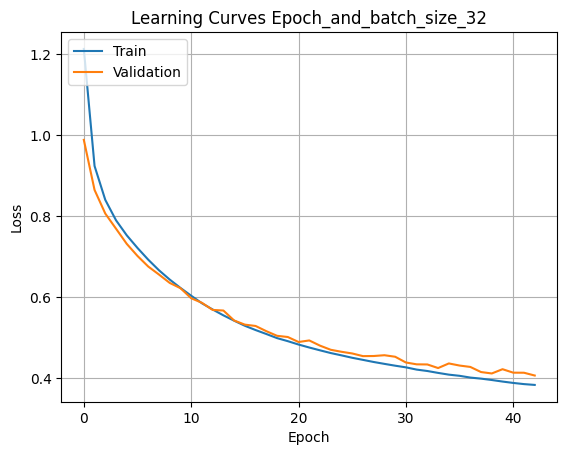

Model: "Epoch_and_batch_size_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                1664      
                                                                 
 dense_18 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
318/318 [==============================] - 2s 4ms/step - loss: 1.2952 - accuracy: 0.5722 - val_loss: 1.0713 - val_accuracy: 0.6350
Epoch 2/200
318/318 [==============================] - 1s 3ms/step - loss: 0.9893 - accuracy: 0.6579 - val_loss: 0.9132 - val_accuracy: 0.6767
Epoch 3/200
318/318 [==============================] - 1s 3ms/step - loss: 0.8836 - accuracy: 0.6847 - val_loss: 0.8446 -

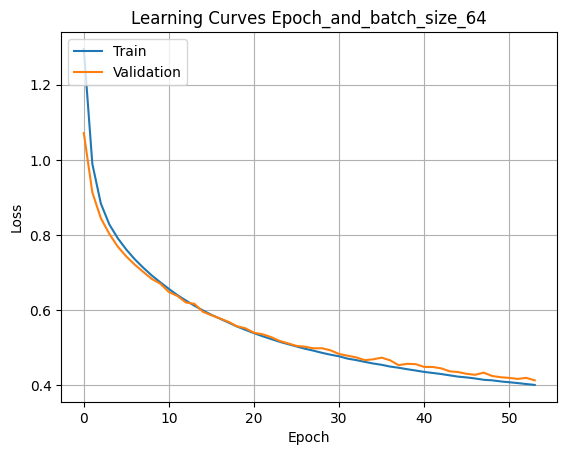

Model: "Epoch_and_batch_size_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                1664      
                                                                 
 dense_20 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
159/159 [==============================] - 1s 4ms/step - loss: 1.4215 - accuracy: 0.4910 - val_loss: 1.2428 - val_accuracy: 0.5953
Epoch 2/200
159/159 [==============================] - 0s 2ms/step - loss: 1.1403 - accuracy: 0.6110 - val_loss: 1.0451 - val_accuracy: 0.6303
Epoch 3/200
159/159 [==============================] - 0s 3ms/step - loss: 0.9986 - accuracy: 0.6482 - val_loss: 0.9422 

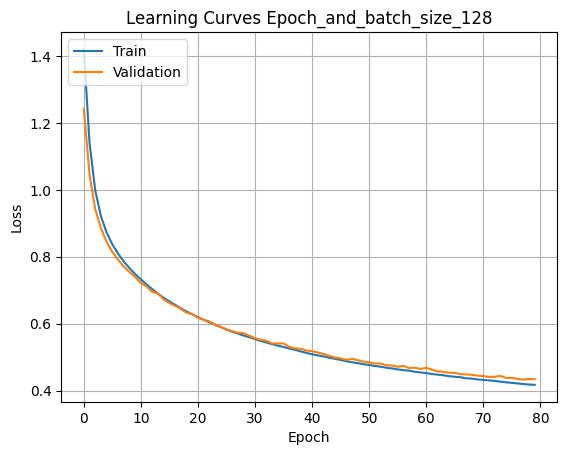

In [ ]:
accuracy_measures = {}
model_config = get_base_model_config()

batch_sizes = [32, 64, 128]

for size in batch_sizes:

  model_config['batch_size'] = size

  custom_layers = [
      layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];
  model_name = 'Epoch_and_batch_size_' + str(size)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_batch_epoch = accuracy_measures.copy()

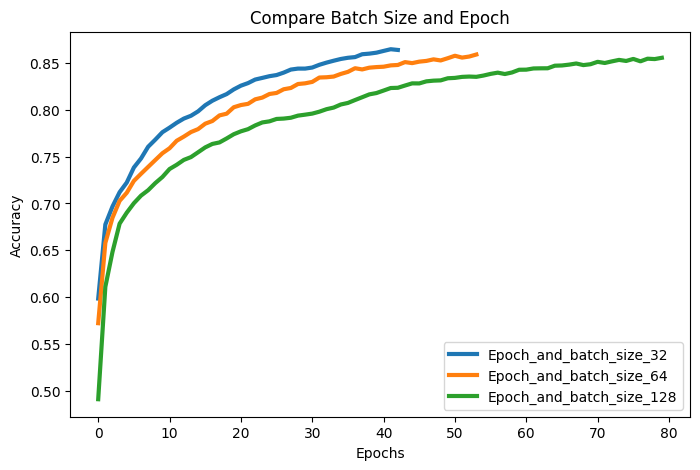

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Batch Size and Epoch")

For this use case, it seems there is no benefits on increasing the batch size further. Moving forward I am just going to use the batch size of 32.\
Meanwhile, the earliest epoch where stabilization happens was 50.

In [ ]:
model_config['batch_size'] = 32
model_config['epochs'] = 50

NameError: ignored

### Hidden layers tuning

One of the key model architecture hyperparameters is the number of hidden layers. As the number of layers increases, it increases the possibility of learning complex relationships between features and target variables, but it will also increase the cost and time needed for both training and inference. It is also has the risk of overfitting the training set.

A **value of two** has been sufficient for simple problems. It is recommended to increase the number of layers only based on experimentation if the set accuracy levels are not achieved. Otherwise, additional layers will take resources and time without providing any additional value.

Model: "Layers_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                1664      
                                                                 
 dense_31 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1829 (7.14 KB)
Trainable params: 1829 (7.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 1.2125 - accuracy: 0.5740 - val_loss: 0.9751 - val_accuracy: 0.6667
Epoch 2/50
636/636 [==============================] - 2s 3ms/step - loss: 0.9019 - accuracy: 0.6868 - val_loss: 0.8353 - val_accuracy: 0.7024
Epoch 3/50
636/636 [==============================] - 2s 3ms/step - loss: 0.8087 - accuracy: 0.7104 - val_loss: 0.7693 - val_accuracy: 0.7

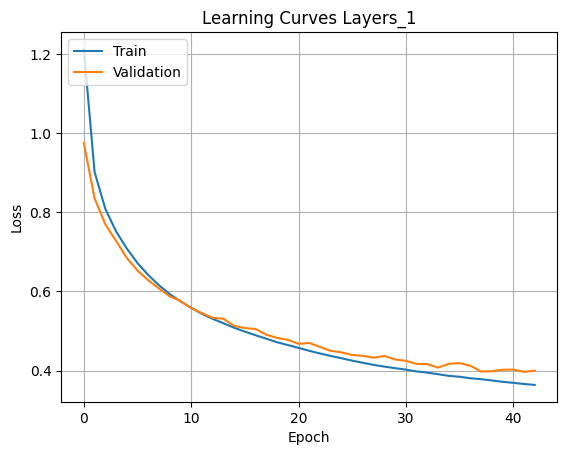

Model: "Layers_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 32)                1664      
                                                                 
 dense_33 (Dense)            (None, 32)                1056      
                                                                 
 dense_34 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2885 (11.27 KB)
Trainable params: 2885 (11.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.1371 - accuracy: 0.5953 - val_loss: 0.8700 - val_accuracy: 0.6816
Epoch 2/50
636/636 [==============================] - 2s 3ms/step - loss: 0.8148 - accuracy: 0.7053 - val_loss: 0.7572 - val_accuracy: 0.7256
Epoc

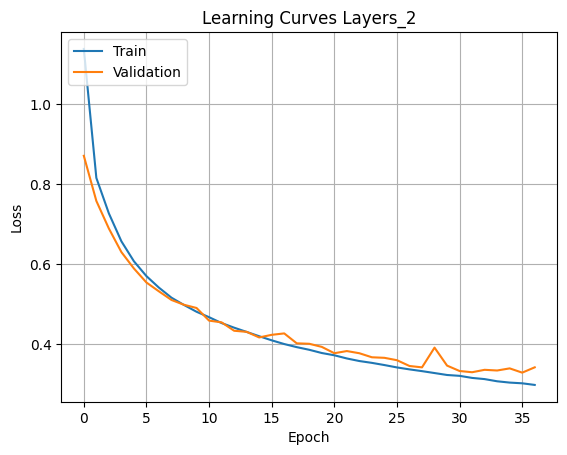

Model: "Layers_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 32)                1664      
                                                                 
 dense_36 (Dense)            (None, 32)                1056      
                                                                 
 dense_37 (Dense)            (None, 32)                1056      
                                                                 
 dense_38 (Dense)            (None, 5)                 165       
                                                                 
Total params: 3941 (15.39 KB)
Trainable params: 3941 (15.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 1.0792 - accuracy: 0.6151 - val_loss: 0.8219 - val_accuracy: 0.7081
Epoch 2/50
636

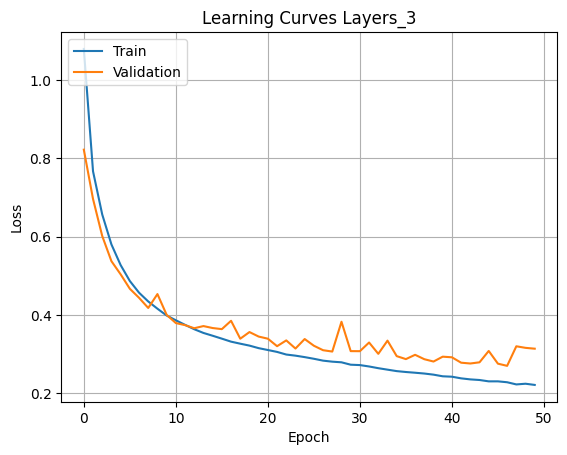

Model: "Layers_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                1664      
                                                                 
 dense_40 (Dense)            (None, 32)                1056      
                                                                 
 dense_41 (Dense)            (None, 32)                1056      
                                                                 
 dense_42 (Dense)            (None, 32)                1056      
                                                                 
 dense_43 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4997 (19.52 KB)
Trainable params: 4997 (19.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [====

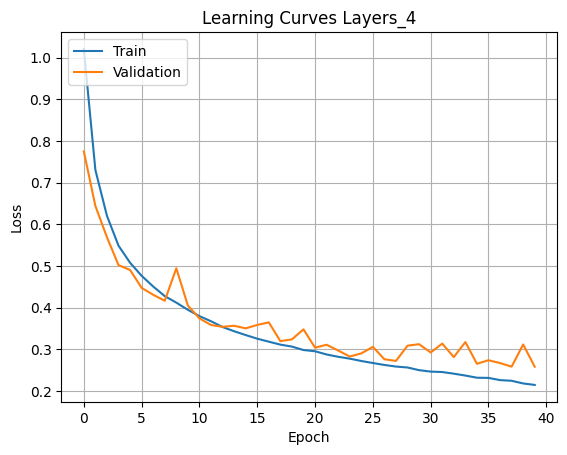

Model: "Layers_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 32)                1664      
                                                                 
 dense_45 (Dense)            (None, 32)                1056      
                                                                 
 dense_46 (Dense)            (None, 32)                1056      
                                                                 
 dense_47 (Dense)            (None, 32)                1056      
                                                                 
 dense_48 (Dense)            (None, 32)                1056      
                                                                 
 dense_49 (Dense)            (None, 5)                 165       
                                                                 
Total params: 6053 (23.64 KB)
Trainable params: 6053 (23.6

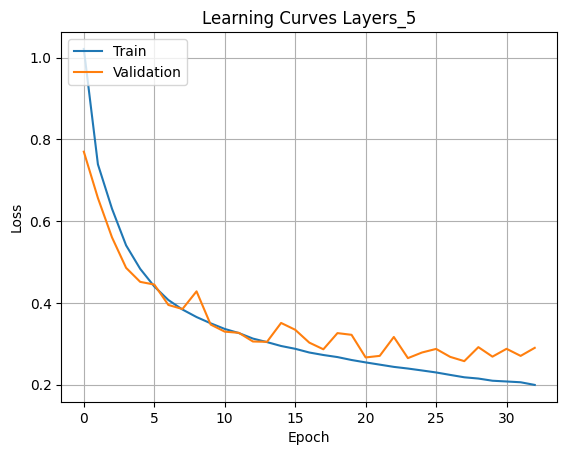

In [ ]:
model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50

accuracy_measures = {}

# reused the previous model config from previous experiment.
# but on this case only increase the number of layers

# I will start small by checking if one or two nodes is enough to get a good result.
layer_list = []
for hidden_layer_count in range(1,3):
  custom_layers = []

  # Simply use 32 nodes per layer for now.

  # Input
  if hidden_layer_count == 1:
    custom_layers.append(layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
  else:
  # Additional Layers
    custom_layers.append(layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
    for i in range(1, hidden_layer_count):
      custom_layers.append(layers.Dense(32, activation=model_config['hidden_activation']))

  # Output layers
  custom_layers.append(layers.Dense(model_config['output_nodes'], activation=model_config['output_activation']))

  model_name = 'Layers_' + str(hidden_layer_count)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_hidden_layers = accuracy_measures.copy()

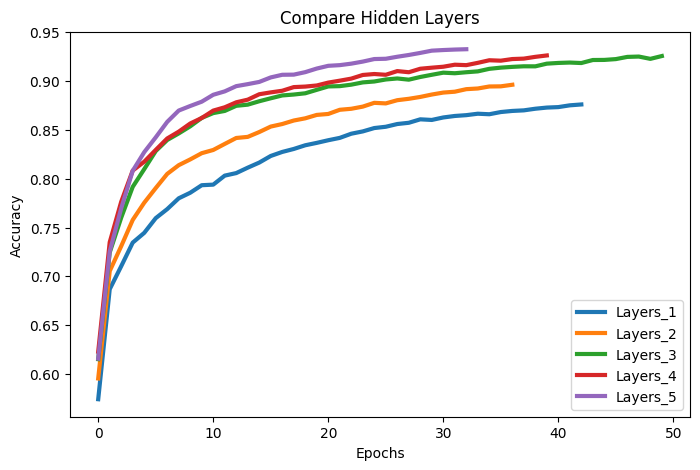

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Hidden Layers")

The experiment suggest that 5 layers starts with higher accuracy and was able to complete faster. However, I will start small by selecting three layers for now and optimize it. If the result is still not satisfying then I will consider on adding more layers.

### Determining nodes in a layers
More nodes means more possibility for the model to learn complex relationships. However similar to number of layers, it will results to more training and resources.

On my experiment I started with a low number as recommended with 32 nodes.


Model: "Nodes-128-128-128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6656      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 40325 (157.52 KB)
Trainable params: 40325 (157.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 8s 4ms/step - loss: 0.8471 - accuracy: 0.6875 - val_loss: 0.6045 - val_accuracy: 0.7710


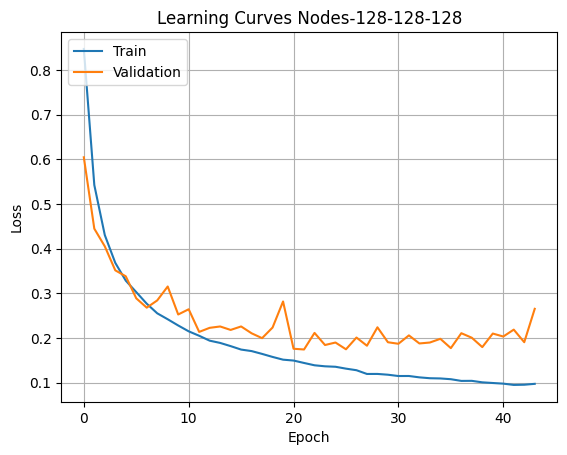

Model: "Nodes-128-128-64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               6656      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.8828 - accuracy: 0.6761 - val_loss: 0.6537 - val_accuracy: 0.7510
E

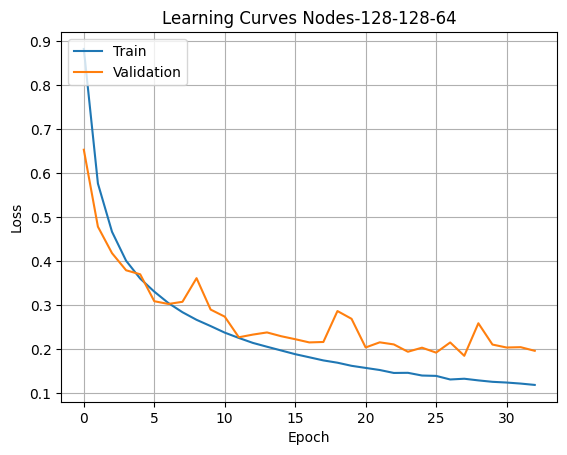

Model: "Nodes-128-128-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               6656      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 27461 (107.27 KB)
Trainable params: 27461 (107.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.8979 - accuracy: 0.6727 - val_loss: 0.6840 - val_accuracy: 0.7471
E

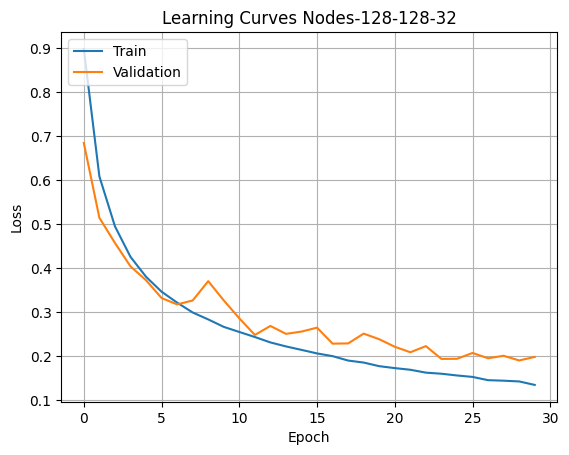

Model: "Nodes-128-64-128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               6656      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 23877 (93.27 KB)
Trainable params: 23877 (93.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.8926 - accuracy: 0.6730 - val_loss: 0.6443 - val_accuracy: 0.7649
Epo

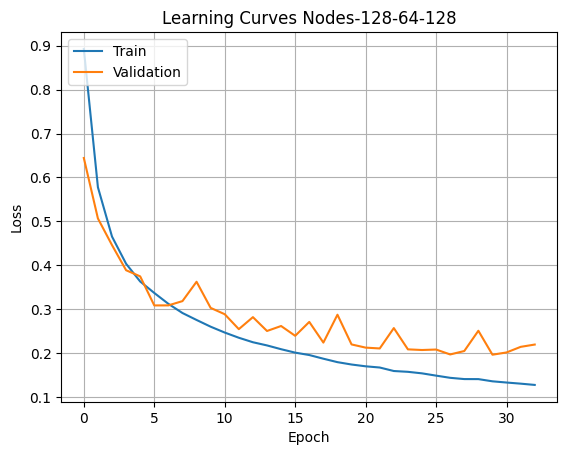

Model: "Nodes-128-64-64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               6656      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 19397 (75.77 KB)
Trainable params: 19397 (75.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.9111 - accuracy: 0.6680 - val_loss: 0.6821 - val_accuracy: 0.7425
Epoc

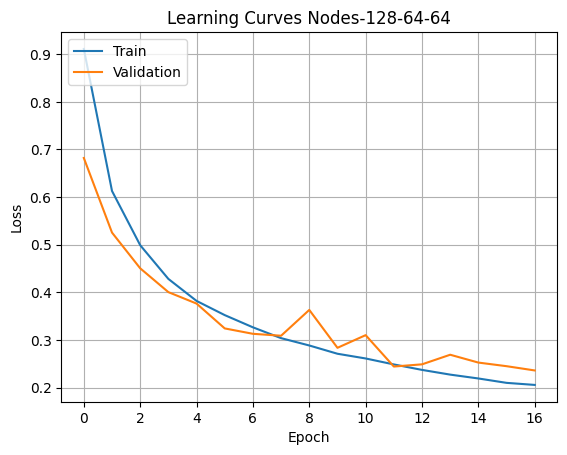

Model: "Nodes-128-64-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               6656      
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 5)                 165       
                                                                 
Total params: 17157 (67.02 KB)
Trainable params: 17157 (67.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 5s 7ms/step - loss: 0.9779 - accuracy: 0.6457 - val_loss: 0.7501 - val_accuracy: 0.7331
Epoc

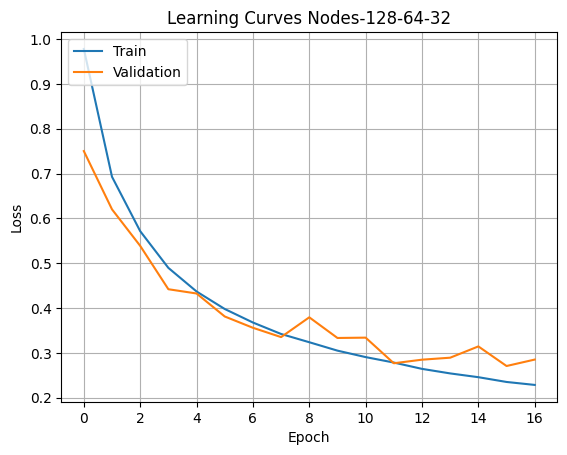

Model: "Nodes-128-32-128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               6656      
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                                 
 dense_26 (Dense)            (None, 128)               4224      
                                                                 
 dense_27 (Dense)            (None, 5)                 645       
                                                                 
Total params: 15653 (61.14 KB)
Trainable params: 15653 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.9347 - accuracy: 0.6602 - val_loss: 0.7054 - val_accuracy: 0.7423
Epo

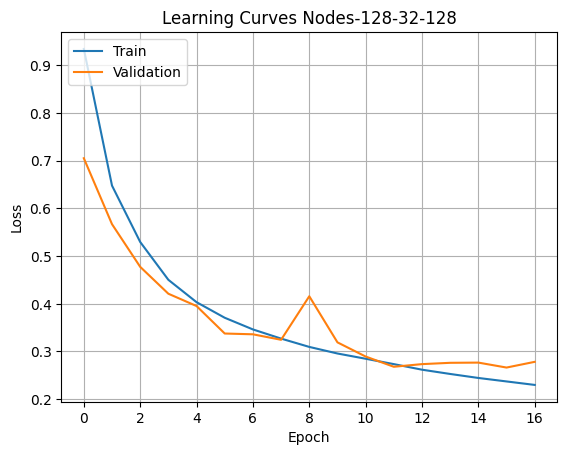

Model: "Nodes-128-32-64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               6656      
                                                                 
 dense_29 (Dense)            (None, 32)                4128      
                                                                 
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 dense_31 (Dense)            (None, 5)                 325       
                                                                 
Total params: 13221 (51.64 KB)
Trainable params: 13221 (51.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 0.9452 - accuracy: 0.6581 - val_loss: 0.7100 - val_accuracy: 0.7280
Epoc

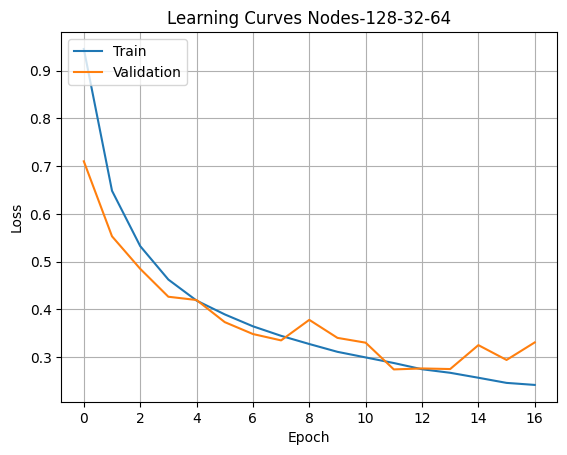

Model: "Nodes-128-32-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               6656      
                                                                 
 dense_33 (Dense)            (None, 32)                4128      
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 5)                 165       
                                                                 
Total params: 12005 (46.89 KB)
Trainable params: 12005 (46.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 5s 6ms/step - loss: 0.9716 - accuracy: 0.6497 - val_loss: 0.7471 - val_accuracy: 0.7215
Epoc

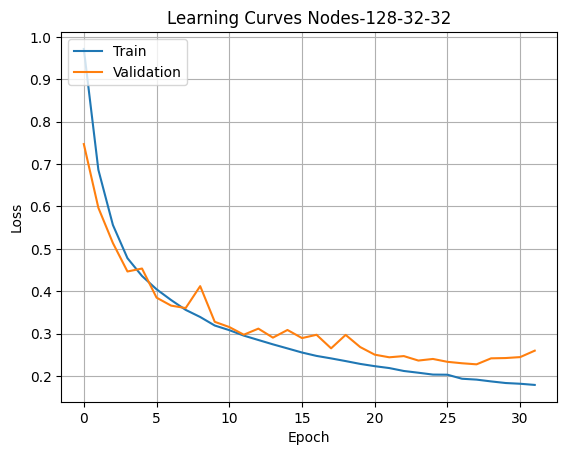

In [ ]:
# reset the accuracy measures
accuracy_measures = {}
model_config = get_base_model_config()

# The list used to have 16, 128 and 256 nodes. I removed those because of resources and performance reasons.
# The result is little improvement on the model accuracy and I also noticed it just caused an overfitting.
# Hence, I am using a nodes combination below on my experiments

#node_list_layer_1 = [32, 64, 128]
#node_list_layer_2 = [32, 64, 128]
#node_list_layer_3 = [32, 64, 128]
node_list_layer_1 = [128]
node_list_layer_2 = [128, 64, 32]
node_list_layer_3 = [128, 64, 32]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    for nbr_of_nodes_layer_3 in node_list_layer_3:
      custom_layers = [
        layers.Dense(nbr_of_nodes_layer_1, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
        layers.Dense(nbr_of_nodes_layer_2, activation=model_config['hidden_activation']),
        layers.Dense(nbr_of_nodes_layer_3, activation=model_config['hidden_activation']),
        layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
      ];

      model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
      model_config['model_name'] = model_name
      model_config['custom_layers'].clear()
      model_config['custom_layers'].extend(custom_layers)

      history = create_and_run_model(model_config, X_train, y_train_dummy)
      plot_learning_curves(history, model_name)
      accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_nodes = accuracy_measures.copy()

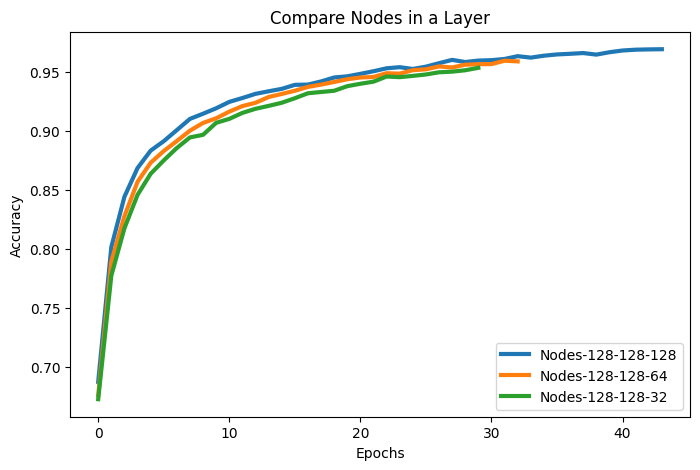

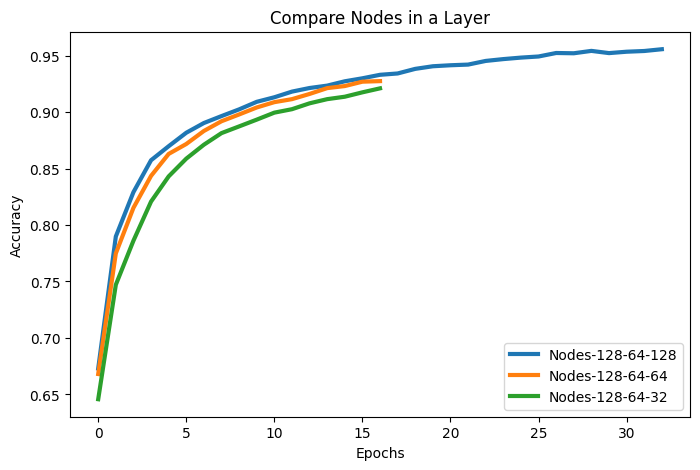

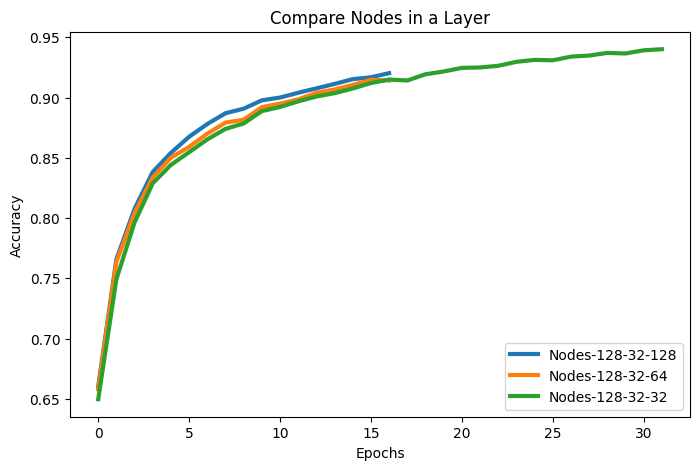

In [ ]:
accuracy_measures_tmp = {}

node_list_layer_1 = [128]
node_list_layer_2 = [128, 64, 32]
node_list_layer_3 = [128, 64, 32]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    accuracy_measures_tmp = {}
    for nbr_of_nodes_layer_3 in node_list_layer_3:
      model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
      accuracy_measures_tmp[model_name] = accuracy_measures[model_name]
    plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

In [59]:
accuracy_measures_tmp = {}
#accuracy_measures_tmp['Nodes-128-128-64'] = accuracy_measures['Nodes-128-128-64']
#accuracy_measures_tmp['Nodes-128-64-64'] = accuracy_measures['Nodes-128-64-64']
#accuracy_measures_tmp['Nodes-128-32-128'] = accuracy_measures['Nodes-128-32-128']
#accuracy_measures_tmp['Nodes-128-64-32'] = accuracy_measures['Nodes-128-64-32']

#plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

The nodes 128 and 64 was faster to complete compared to other combination of nodes and it also offer a good accuracy. The model 128 nodes for both layers have a higher accuracy but it can lead to overfitting. I will use two layers with 128 and 64 nodes assigned respectively.

### Choosing Activation Function

There are number of algorithms available for activation functions. In general, rectified linear unit works best for regular  artificial neural network (ANN) and convolutional network (CNN). Sigmoid works best for RNNs.


Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               6656      
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 5s 6ms/step - loss: 0.8921 - accuracy: 0.6734 - val_loss: 0.6734 - val_accuracy: 0.7482
Epoch 2/

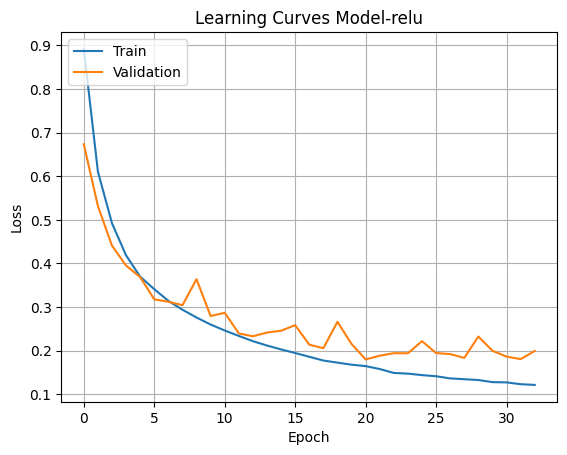

Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               6656      
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 6ms/step - loss: 1.5168 - accuracy: 0.3133 - val_loss: 1.3172 - val_accuracy: 0.4729
Epoch

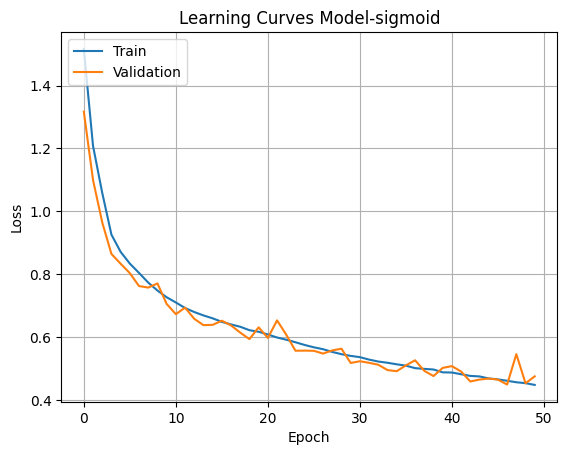

Model: "Model-tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               6656      
                                                                 
 dense_45 (Dense)            (None, 128)               16512     
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 dense_47 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 0.8595 - accuracy: 0.6814 - val_loss: 0.7112 - val_accuracy: 0.7327
Epoch 2/

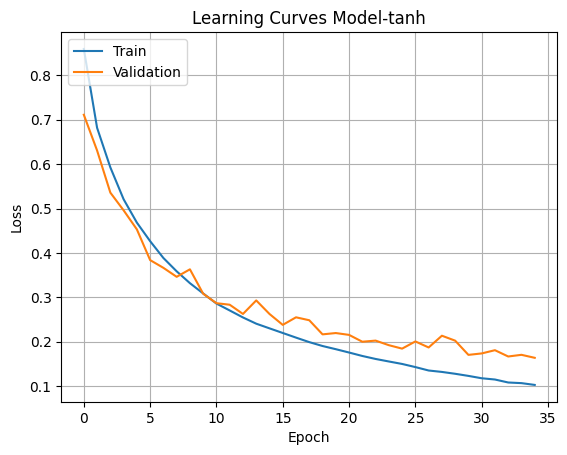

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 128 64

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:

  model_config['hidden_activation'] = activation

  custom_layers = [
    layers.Dense(128, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(128, activation=model_config['hidden_activation']),
    layers.Dense(64, activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + activation
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_activation = accuracy_measures.copy()

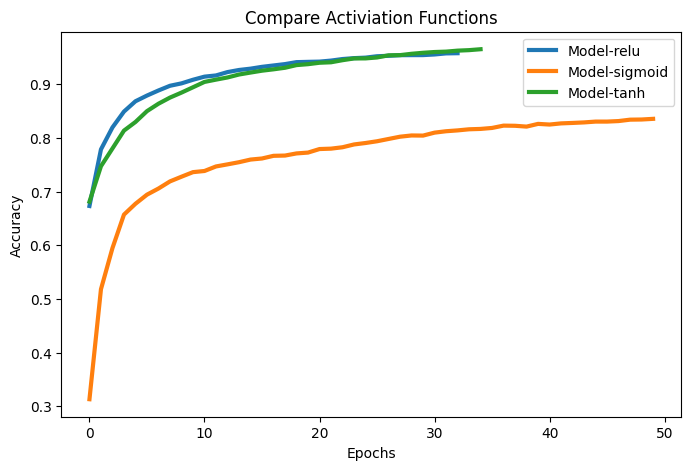

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Activiation Functions")

The activation function relu have higher accuracy and completed faster.

In [19]:
model_config['hidden_activation'] = 'tanh'

### Initialize Weights
The initial values of weights play a huge role in the speed of learning and finaly accuracy. Multiple initialization techniques exist.

Random normal works best for most cases but we will run an experiment if that is still the case on our dataset.

Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               6656      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 6s 6ms/step - loss: 0.8826 - accuracy: 0.6726 - val_loss: 0.7364 - val_accuracy: 0.7205

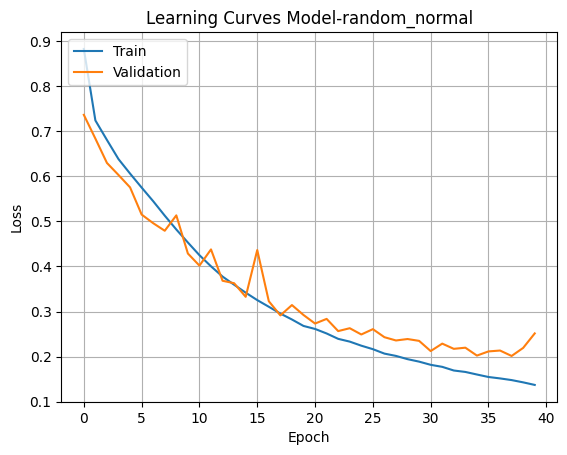

Model: "Model-zeros"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               6656      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.6077 - accuracy: 0.2128 - val_loss: 1.6052 - val_accuracy: 0.2140
Epoch 2

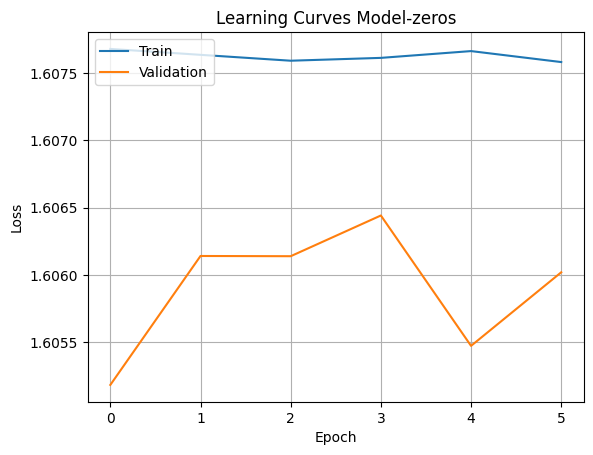

Model: "Model-ones"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               6656      
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 1.6134 - accuracy: 0.2079 - val_loss: 1.6084 - val_accuracy: 0.2134
Epoch 2/

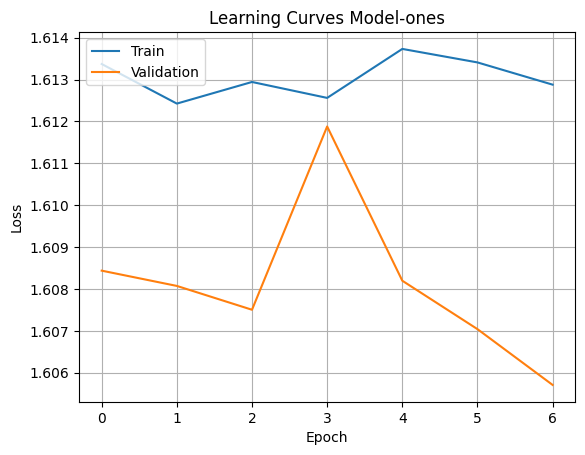

Model: "Model-random_uniform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               6656      
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 0.9220 - accuracy: 0.6533 - val_loss: 0.7491 - val_accuracy: 0.720

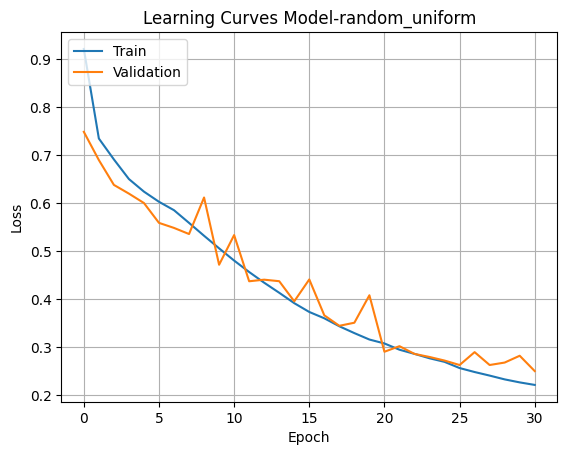

In [20]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'

initializer_list = ['random_normal','zeros','ones',"random_uniform"]

for initializer in initializer_list:

  model_config['weights_initializer'] = initializer

  custom_layers = [
    layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(128,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + initializer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_weight_init = accuracy_measures.copy()

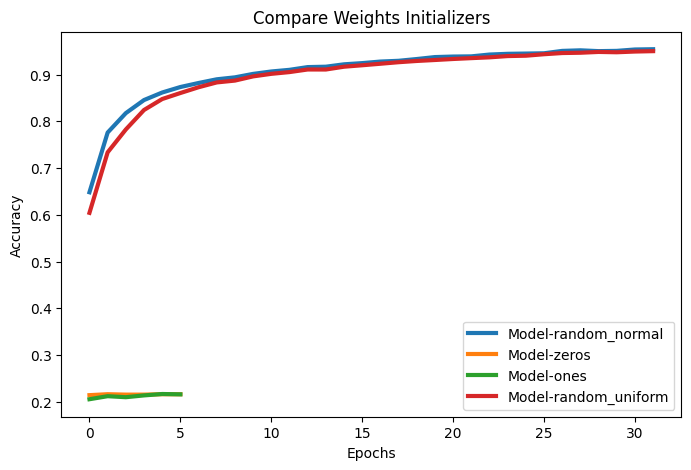

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Weights Initializers")

Both random_normal and random_uniform have similar high accuracy but random_normal completed faster. Hence, I will simply choose the random_normal as weight initializer.

In [ ]:
model_config['weights_initializer'] = 'random_normal'

## Tuning Back Propagation

### Batch Normalization

Batch normalization is an important technique to vanishing and exploiting gradients during gradient descent. Batch normalization help achieve higher accuracies with lower epochs, hence is also an optimization technique.

*This is no longer necessary because Scaler was already applied during data preparation.*

In [ ]:
'''
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 128 64
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'

normalization_list = ['batch','none']
for normalization in normalization_list:

  custom_layers = []
  if normalization == 'none':
    custom_layers = [
      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.BatchNormalization(),
      layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];


  model_name = 'Normalization-' + normalization
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']
'''

"\naccuracy_measures = {}\n\nmodel_config = get_base_model_config()\n# Hyperparameters:\nmodel_config['batch_size'] = 32\nmodel_config['epochs'] = 50\n# Number of layers: 2\n# Number of nodes per each layer: 128 64\nmodel_config['hidden_activation'] = 'relu'\nmodel_config['weights_initializer'] = 'random_normal'\n\nnormalization_list = ['batch','none']\nfor normalization in normalization_list:\n\n  custom_layers = []\n  if normalization == 'none':\n    custom_layers = [\n      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),\n      layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),\n      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])\n    ];  \n  else:\n    custom_layers = [\n      layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=mo

In [ ]:
#accuracy_measures_normalization = accuracy_measures.copy()

In [ ]:
#plot_accuracy_measures(accuracy_measures, "Compare Normalization Techniques")

The model with Batch normalization starts with higher accuracy and faster to stabilize and complete compared to the other model without normalization.

### Optimizers
Optimizer are key tools, that help gradient descent, achieve faster results. Optimizers are algorithms, that helps speed up the training process.

Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               6656      
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 2s 3ms/step - loss: 0.8892 - accuracy: 0.6695 - val_loss: 0.7386 - val_accuracy: 0.7223
Epoch

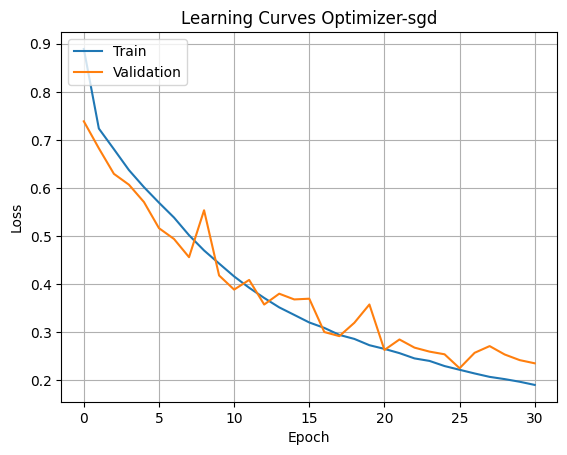

Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               6656      
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 0.8873 - accuracy: 0.6718 - val_loss: 0.7318 - val_accuracy: 0.7229
E

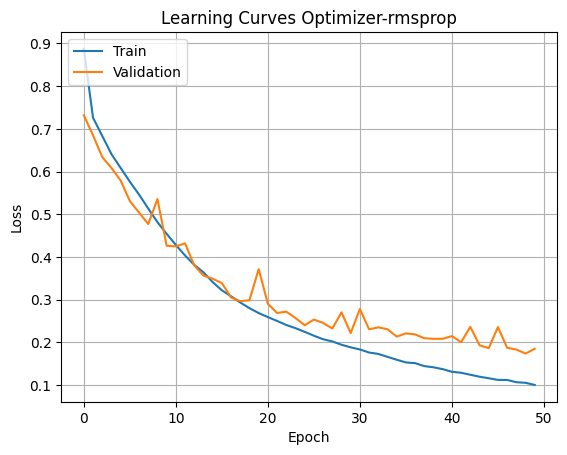

Model: "Optimizer-adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               6656      
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 0.8872 - accuracy: 0.6707 - val_loss: 0.7342 - val_accuracy: 0.7223
Epoc

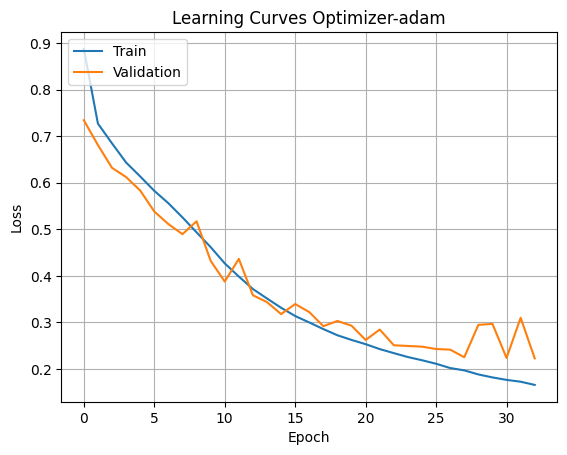

Model: "Optimizer-adagrad"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               6656      
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 1.5988 - accuracy: 0.3306 - val_loss: 1.5858 - val_accuracy: 0.3660
E

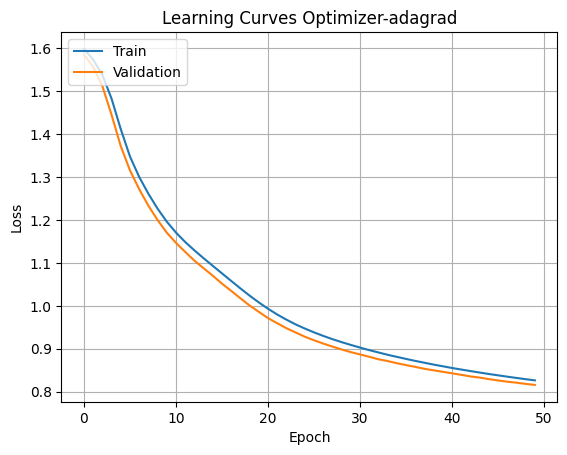

In [21]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: not added

optimizer_list = ['sgd','rmsprop','adam','adagrad']

for optimizer in optimizer_list:

  model_config['optimizer'] = optimizer

  custom_layers = [
    layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(128,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Optimizer-' + optimizer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [22]:
accuracy_measures_optimizer = accuracy_measures.copy()

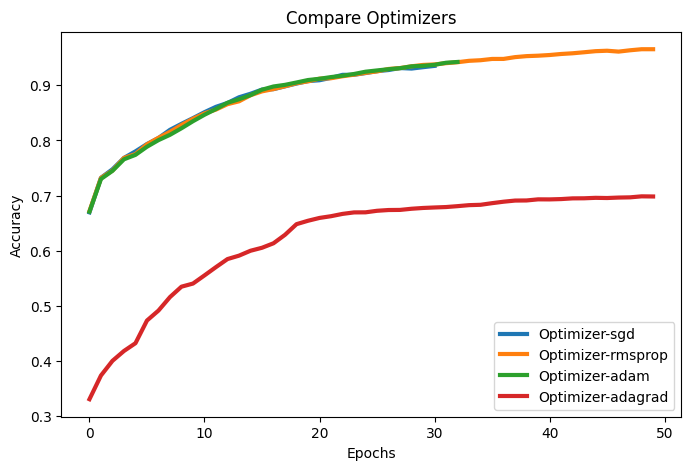

In [23]:
plot_accuracy_measures(accuracy_measures, "Compare Optimizers")

The result is very close, but I will simply use adam for the optimizer.

In [24]:
model_config['optimizer'] = 'rmsprop'

### Learning Rates

Learning rate is the rate at  which the weights will change in response to the estimated error. It is the speed at which the model is expected to learn from the training data and adjust its weights. Learning rates work in conjunction with the optimizer.

Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               6656      
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 0.8917 - accuracy: 0.6706 - val_loss: 0.7360 - val_accuracy: 0.7217

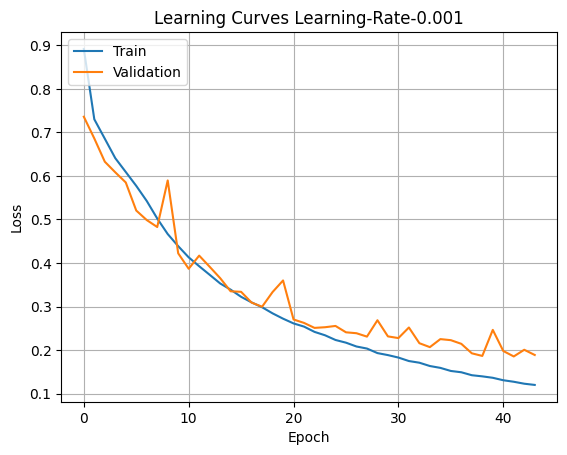

Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               6656      
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 0.9220 - accuracy: 0.6537 - val_loss: 0.7094 - val_accuracy: 0.7402

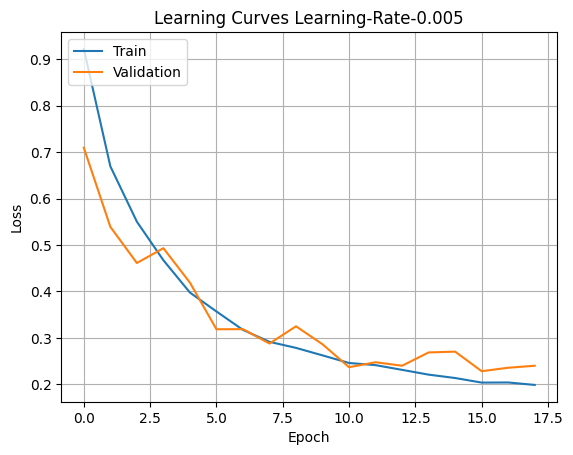

Model: "Learning-Rate-0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               6656      
                                                                 
 dense_45 (Dense)            (None, 128)               16512     
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 dense_47 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 1.0771 - accuracy: 0.5938 - val_loss: 0.7545 - val_accuracy: 0.7388


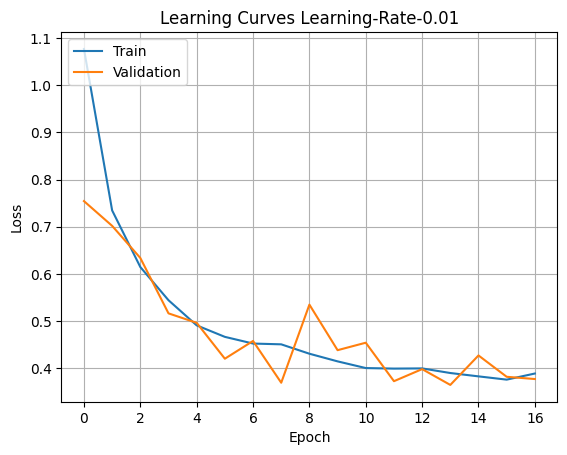

Model: "Learning-Rate-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 128)               6656      
                                                                 
 dense_49 (Dense)            (None, 128)               16512     
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dense_51 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 5.6845 - accuracy: 0.1983 - val_loss: 5.3142 - val_accuracy: 0.1849
E

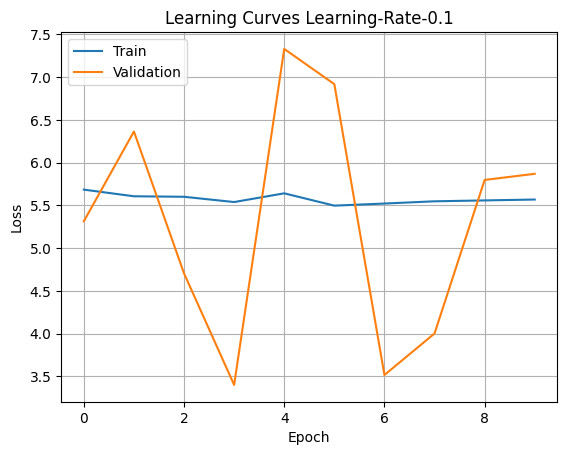

In [25]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: added BatchNormalization between the layers
model_config['optimizer'] = 'rmsprop'

#learning_rate_list = [0.001, 0.005, 0.01, 0.1, 0.5]
learning_rate_list = [0.001, 0.005, 0.01, 0.1]

for learning_rate in learning_rate_list:

  model_config['learning_rate'] = learning_rate

  custom_layers = [
    layers.Dense(128, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(128,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(64,  kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Learning-Rate-' + str(learning_rate)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_learning_rate = accuracy_measures.copy()

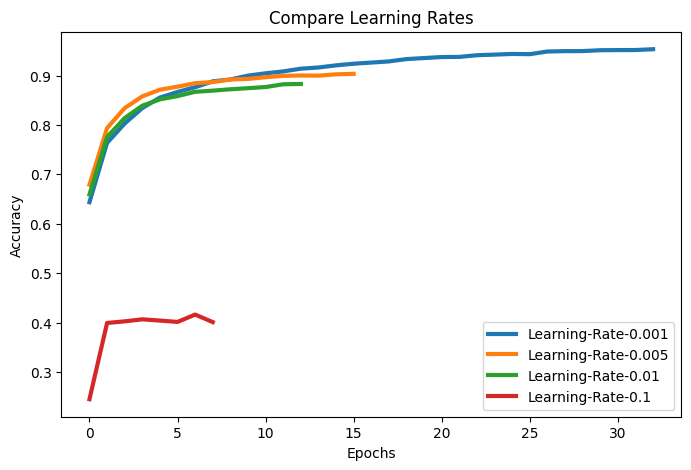

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Learning Rates")

The learning rate 0.001 is the better choice compared to other learning rates because of higher accuracy.

In [ ]:
model_config['learning_rate'] = 0.001

## Overfitting Management

### Regularization
Regularization is an important technique for managing overfitting in neural networks. Regularization algorithms provide an adjustments to the model parameters after they are updated. The adjustment reduces the variance in the model by providing a penalty when overfitting.

Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 128)               6656      
                                                                 
 dense_53 (Dense)            (None, 128)               16512     
                                                                 
 dense_54 (Dense)            (None, 64)                8256      
                                                                 
 dense_55 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 0.8912 - accuracy: 0.6661 - val_loss: 0.7347 - val_accuracy: 0.7239
Ep

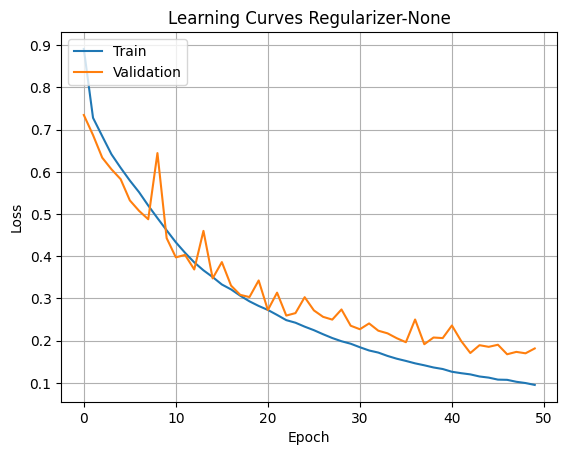

Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 128)               6656      
                                                                 
 dense_57 (Dense)            (None, 128)               16512     
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dense_59 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 2.2405 - accuracy: 0.2121 - val_loss: 1.7603 - val_accuracy: 0.2140
Epoc

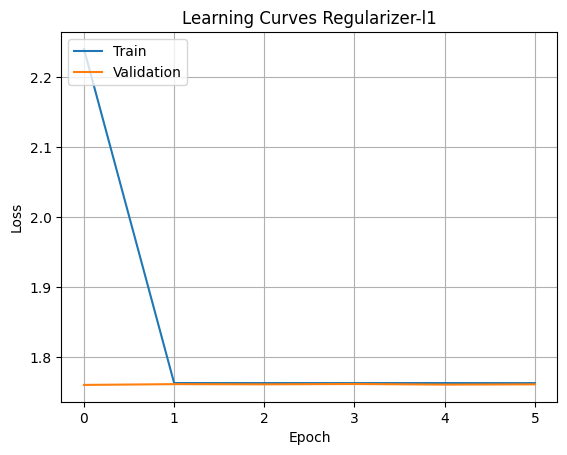

Model: "Regularizer-l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 128)               6656      
                                                                 
 dense_61 (Dense)            (None, 128)               16512     
                                                                 
 dense_62 (Dense)            (None, 64)                8256      
                                                                 
 dense_63 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 1.3218 - accuracy: 0.5842 - val_loss: 1.1507 - val_accuracy: 0.6409
Epoc

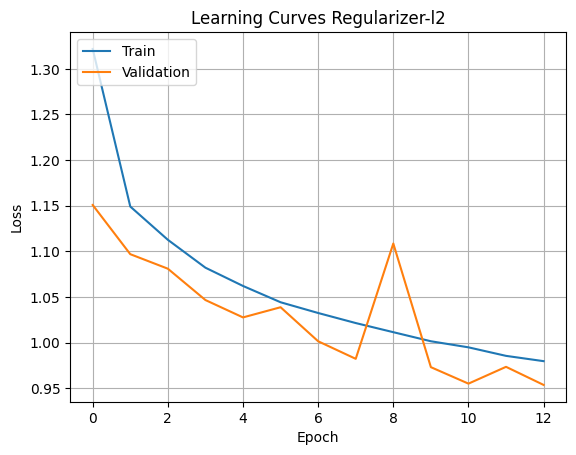

Model: "Regularizer-l1_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 128)               6656      
                                                                 
 dense_65 (Dense)            (None, 128)               16512     
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 dense_67 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 2.2831 - accuracy: 0.2091 - val_loss: 1.7612 - val_accuracy: 0.2140
E

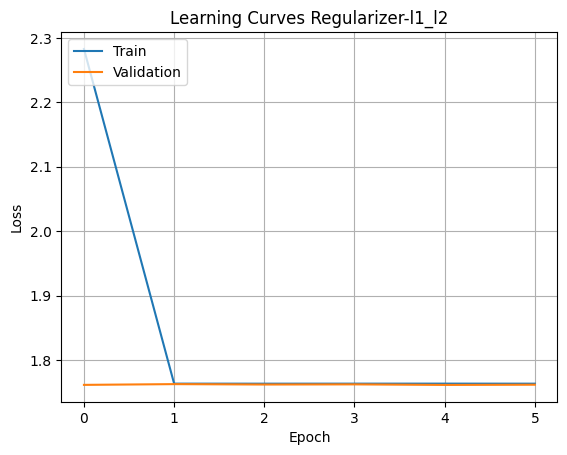

In [26]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: added BatchNormalization between the layers
model_config['optimizer'] = 'rmsprop'
model_config['learning_rate'] = 0.001

regularizer_list = ['None', 'l1','l2','l1_l2']

for regularizer in regularizer_list:
  if regularizer == 'None':
    regularizer = None

  model_config['regularizer'] = regularizer

  custom_layers = [
    layers.Dense(128, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(128,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(64,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Regularizer-' + str(regularizer)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [27]:
accuracy_measures_regularizer = accuracy_measures.copy()

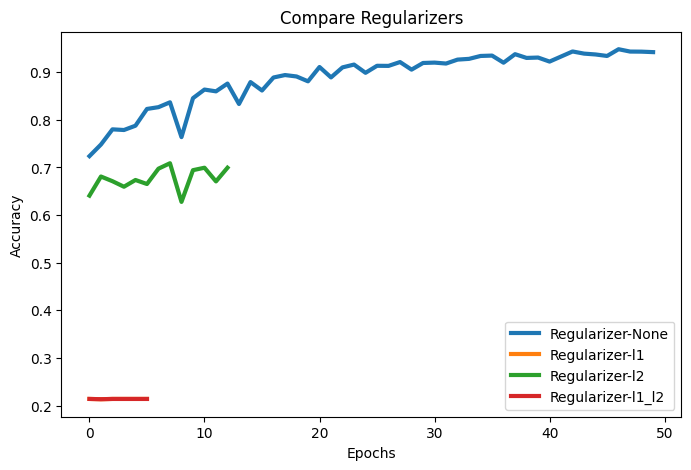

In [28]:
plot_accuracy_measures(accuracy_measures, "Compare Regularizers")

The l2 regularizer produce better accuracy and stability.

In [29]:
model_config['regularizer'] = None

### Dropout
Dropout works during forward propagation. By default, during forward propagation, the  output of each node in the layer is sent every node in the next layer. When using dropout, the outputs of some of the nodes in the layer are dropped randomly.

Model: "Dropout-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 128)               6656      
                                                                 
 dense_69 (Dense)            (None, 128)               16512     
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dense_71 (Dense)            (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 0.8916 - accuracy: 0.6656 - val_loss: 0.7333 - val_accuracy: 0.7241
Epoch 2

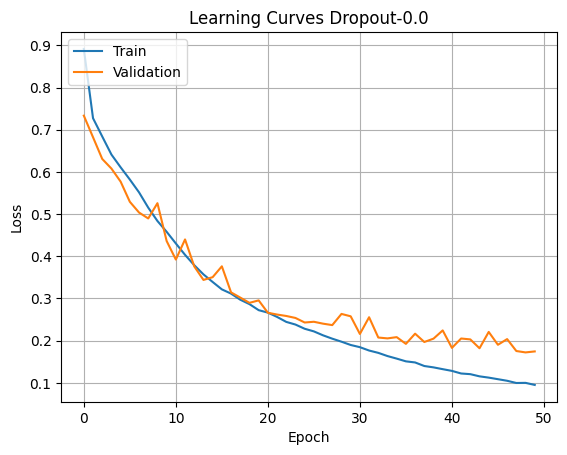

Model: "Dropout-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 128)               6656      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_75 (Dense)            (None, 5)               

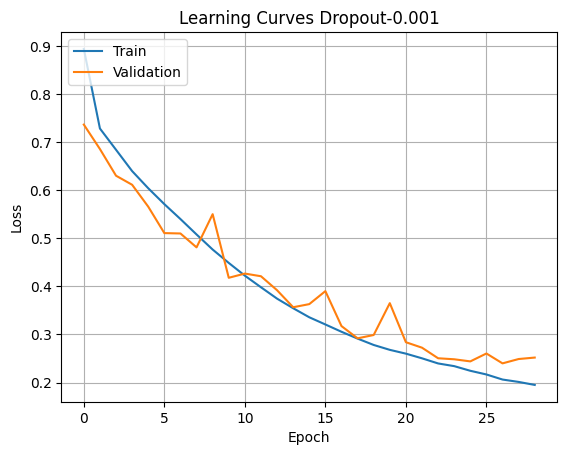

Model: "Dropout-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 128)               6656      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_77 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_78 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_79 (Dense)            (None, 5)                 

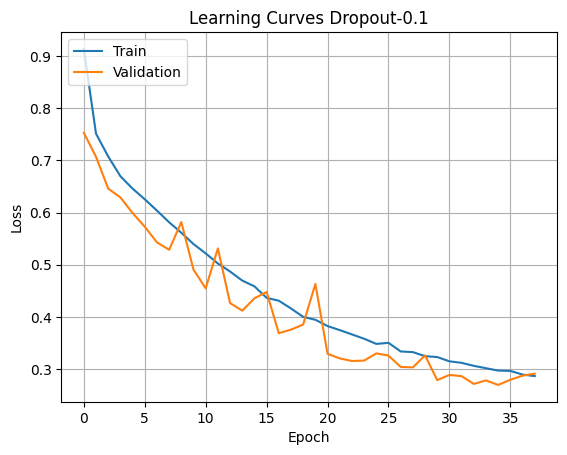

Model: "Dropout-0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 128)               6656      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_83 (Dense)            (None, 5)                 

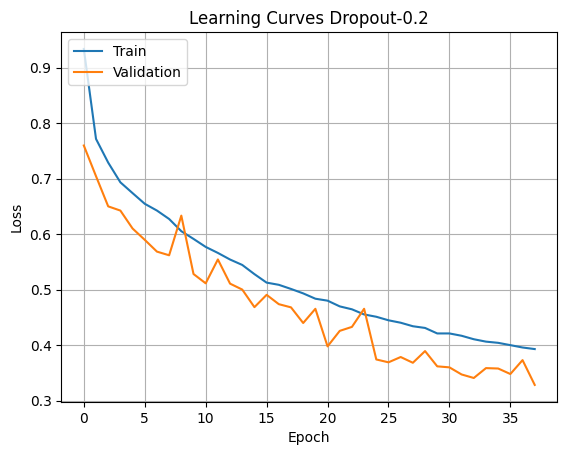

Model: "Dropout-0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 128)               6656      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_87 (Dense)            (None, 5)                 

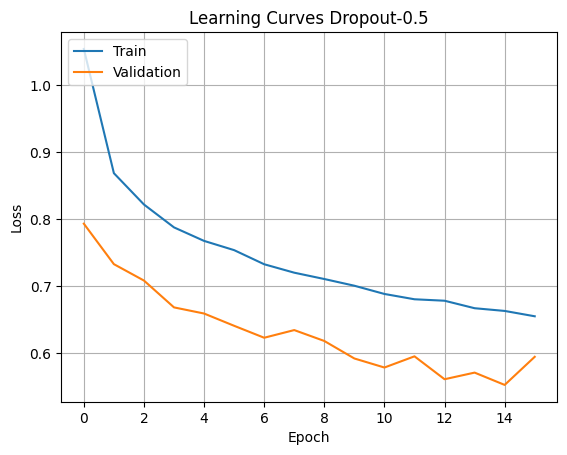

In [30]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 3
# Number of nodes per each layer: 128 64 32
model_config['hidden_activation'] = 'tanh'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: added BatchNormalization between the layers
model_config['optimizer'] = 'rmsprop'
model_config['learning_rate'] = 0.001
model_config['regularizer'] = None
model_config['dropout_rate'] = 0.0

dropout_list = [0.0, 0.001, 0.1, 0.2, 0.5]

for dropout in dropout_list:

  model_config['dropout_rate'] = dropout

  custom_layers = []

  if model_config['dropout_rate'] > 0.0:
    custom_layers = [
      layers.Dense(128, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(128,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(64,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(128, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(128,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(64,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];

  model_name = 'Dropout-' + str(dropout)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [31]:
accuracy_measures_dropout = accuracy_measures.copy()

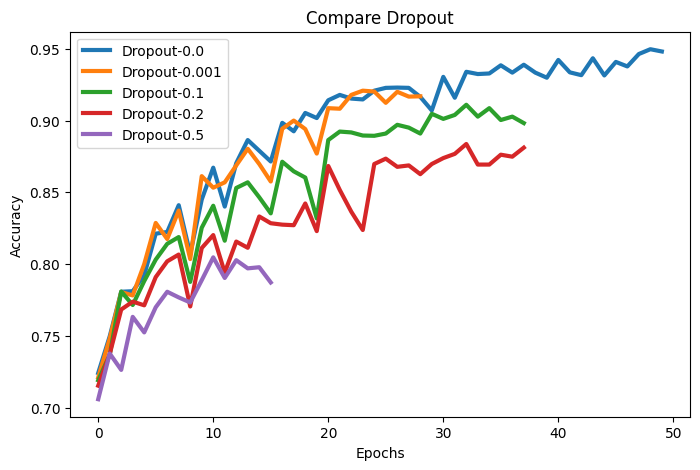

In [32]:
plot_accuracy_measures(accuracy_measures, "Compare Dropout")

I will be using the dropoout rate of 0.1 since it starts on higher accuracy and it show's it is more stable compared to other drop out rates. Another possible candidate is 0.2 but it seems flakey compared to 0.1.

In [33]:
model_config['dropout_rate'] = 0.0

# Model - Evaluation

In [53]:
def get_best_param_model_config(model_name):
  """
  (str) -> dict

  This method returns the best hyper parameters from experiments.

  Parameters
  ----------
  model_name - The name of the model

  Returns
  ----------
  dict - The dictionary containing the best hyper parameters from experiments.
  """
  # Default model config
  model_config = get_base_model_config()

  model_config['model_name'] = model_name

  # These are the final hyperparameters that I will use in training the Models:
  # Hyperparameters:
  model_config['batch_size'] = 32
  model_config['epochs'] = 50
  # Number of layers: 3
  # Number of nodes per each layer: 128 64 32
  model_config['hidden_activation'] = 'tanh'
  model_config['weights_initializer'] = 'random_normal'
  # Batch Normalization: added BatchNormalization between the layers
  model_config['optimizer'] = 'rmsprop'
  model_config['learning_rate'] = 0.001
  model_config['regularizer'] = None
  #model_config['dropout_rate'] = 0.0

  custom_layers = [
    layers.Dense(128, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    #layers.Dropout(model_config['dropout_rate']),
    layers.Dense(128,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    #layers.Dropout(model_config['dropout_rate']),
    layers.Dense(64,  kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    #layers.Dropout(model_config['dropout_rate']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  # we would like to save the model starting here for evaluation.
  model_config['is_save_model'] = True

  return model_config

In [54]:
from keras.models import load_model

def evaluate_model(model_config, X, y):
  """
  (dict, tf.data.Dataset)

  This is a reusable function that load a previously trained model and run an evaluation.

  Parameters
  ----------
  model_config - The dictionary to use in model evaluation.
  test_ds - The test dataset to use in the evaluation.

  Returns
  ----------
  Dataframe - The Panda Dataframe containing the scores from the experiment. The scores includes the Accuracy and Loss.
  """
  model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
  model = load_model(model_file)


  #result = model.evaluate(test_ds)

  #result_in_dict = dict(zip(model.metrics_names, result))

  #loss = result_in_dit['loss']
  #accuracy = result_in_dict['accuracy']

  #scores_df = pd.DataFrame([[accuracy, loss]], ['Score'], ['Accuracy', 'Loss'])

  #return scores_df
  test_loss, test_acc = model.evaluate(X, y, verbose=2)
  print(f"Test accuracy: {test_acc}")

In [55]:
# reset accuracy measures
accuracy_measures = {}

In [56]:
model_name = 'model_c2_3layers'
model_config = get_best_param_model_config(model_name)

model_1_history = create_and_run_model(model_config, X_train, y_train_dummy)

Model: "model_c2_3layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 128)               6656      
                                                                 
 dense_101 (Dense)           (None, 128)               16512     
                                                                 
 dense_102 (Dense)           (None, 64)                8256      
                                                                 
 dense_103 (Dense)           (None, 5)                 325       
                                                                 
Total params: 31749 (124.02 KB)
Trainable params: 31749 (124.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 3ms/step - loss: 0.8913 - accuracy: 0.6685 - val_loss: 0.7347 - val_accuracy: 0.7174
Ep

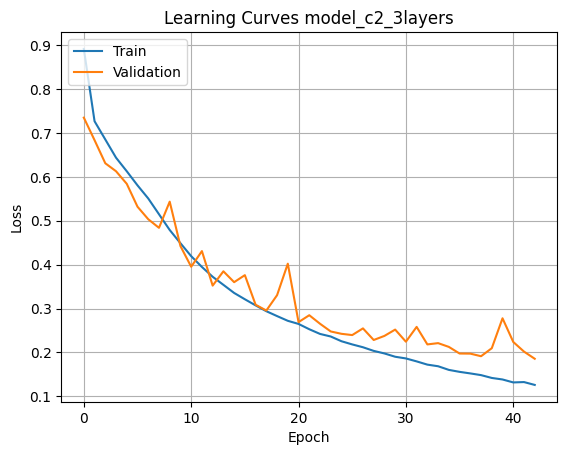

In [57]:
plot_learning_curves(model_1_history, model_name)

In [58]:
evaluate_model(model_config, X_test, y_test_dummy)

341/341 - 1s - loss: 0.1842 - accuracy: 0.9439 - 624ms/epoch - 2ms/step
Test accuracy: 0.9438635110855103
